In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

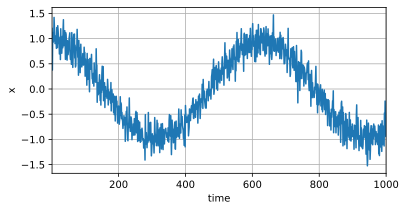

In [2]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.cos(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [4]:
"""
feature:
[x_0, x_1, x_2, x_3],          -> x_4
[x_1, x_2, x_3, x_4],          -> x_5
...
[x_995, x_996, x_997, x_998],  -> x_999

"""
features[0:10]

tensor([[1.2013, 0.3764, 1.1223, 0.9246],
        [0.3764, 1.1223, 0.9246, 0.9407],
        [1.1223, 0.9246, 0.9407, 0.9588],
        [0.9246, 0.9407, 0.9588, 1.4196],
        [0.9407, 0.9588, 1.4196, 1.2274],
        [0.9588, 1.4196, 1.2274, 0.9856],
        [1.4196, 1.2274, 0.9856, 0.9007],
        [1.2274, 0.9856, 0.9007, 1.0543],
        [0.9856, 0.9007, 1.0543, 0.9386],
        [0.9007, 1.0543, 0.9386, 1.0056]])

In [5]:
"""
labels:
[x_4],
[x_5],
...
[x_999],
"""
labels[0:10]

tensor([[0.9407],
        [0.9588],
        [1.4196],
        [1.2274],
        [0.9856],
        [0.9007],
        [1.0543],
        [0.9386],
        [1.0056],
        [0.8069]])

In [6]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)
f, l = next(iter(train_iter))
f.shape, l.shape

(torch.Size([16, 4]), torch.Size([16, 1]))

In [7]:
def init_weights(m):
    """ Accelerate model convergence and prevent gradient disappearance or explosion
    """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)

    return net

loss = nn.MSELoss(reduction='none')

In [8]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        net.train()
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        net.eval()
        with torch.no_grad():
            if epoch % 10 == 9:
                print(f"epoch {epoch + 1}, "
                    f"loss: {d2l.evaluate_loss(net, train_iter, loss):f}")

net = get_net()
train(net, train_iter, loss, 100, 0.005)

epoch 10, loss: 0.046653
epoch 20, loss: 0.045589
epoch 30, loss: 0.044897
epoch 40, loss: 0.045016
epoch 50, loss: 0.044359
epoch 60, loss: 0.044268
epoch 70, loss: 0.045186
epoch 80, loss: 0.044740
epoch 90, loss: 0.044535
epoch 100, loss: 0.047668


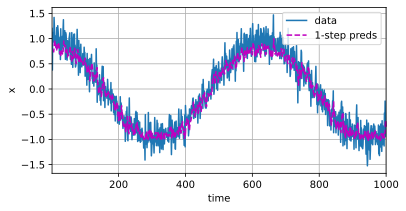

In [9]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

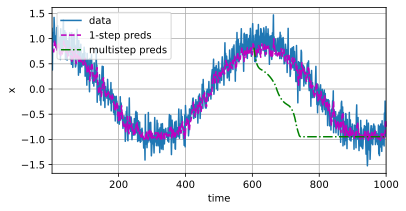

In [10]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [11]:
x[0:10]

tensor([1.2013, 0.3764, 1.1223, 0.9246, 0.9407, 0.9588, 1.4196, 1.2274, 0.9856,
        0.9007])

In [12]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

print(features.shape)
features

torch.Size([933, 68])


tensor([[ 1.2013,  0.3764,  1.1223,  ...,  0.1042,  0.0917,  0.0785],
        [ 0.3764,  1.1223,  0.9246,  ...,  0.1052,  0.0927,  0.0798],
        [ 1.1223,  0.9246,  0.9407,  ...,  0.1102,  0.0979,  0.0852],
        ...,
        [-1.0979, -0.8101, -0.7932,  ..., -0.9466, -0.9466, -0.9466],
        [-0.8101, -0.7932, -0.9680,  ..., -0.9466, -0.9466, -0.9466],
        [-0.7932, -0.9680, -0.7271,  ..., -0.9466, -0.9466, -0.9466]],
       grad_fn=<CopySlices>)

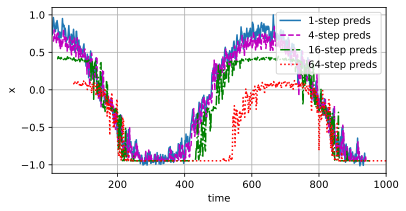

In [13]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))